# Volcanic Eruption Impact on Climate from FLOR Ensemble: Agung 1963
* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['hatch.color']='g'
import xarray as xr
from scipy.stats import ttest_1samp

from plotsetting import *
from geoplots import mapplot, xticksyear, xticksmonth
import geoxarray

%matplotlib notebook
!date

Tue Feb 13 10:14:11 EST 2018


In [3]:
from data_CTL1860 import open_ensemble as get_ctl
from data_agung import open_data as get_volcano
volcano_name = 'Agung'
year_volcano = 1963
ens = range(1,31)
nbname = 'volcano_impact_on_climate_agung.ipynb'
new_names = {'grid_xt': 'lon', 'grid_yt': 'lat'}

### Surface downward solar radiation ``swdn_sfc``

In [67]:
%%time
data_name = 'swdn_sfc'

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_agung.ipynb.swdn_sfc.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.swdn_sfc.nc
CPU times: user 67 ms, sys: 1.1 s, total: 1.17 s
Wall time: 31.9 s


In [68]:
%%time
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

CPU times: user 6.52 s, sys: 3.65 s, total: 10.2 s
Wall time: 10.1 s


<IPython.core.display.Javascript object>


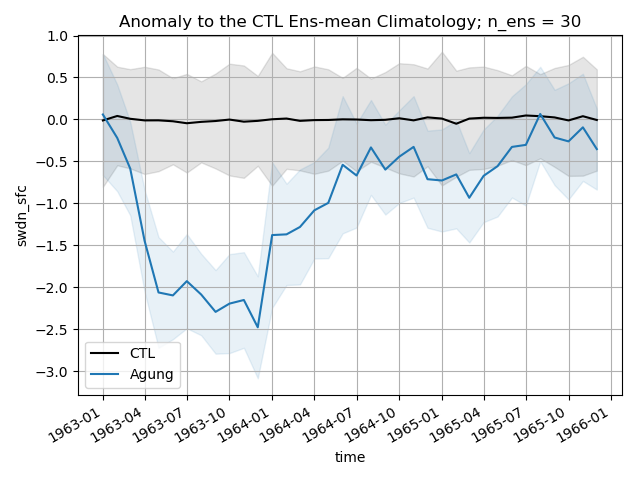

In [66]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

In [7]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


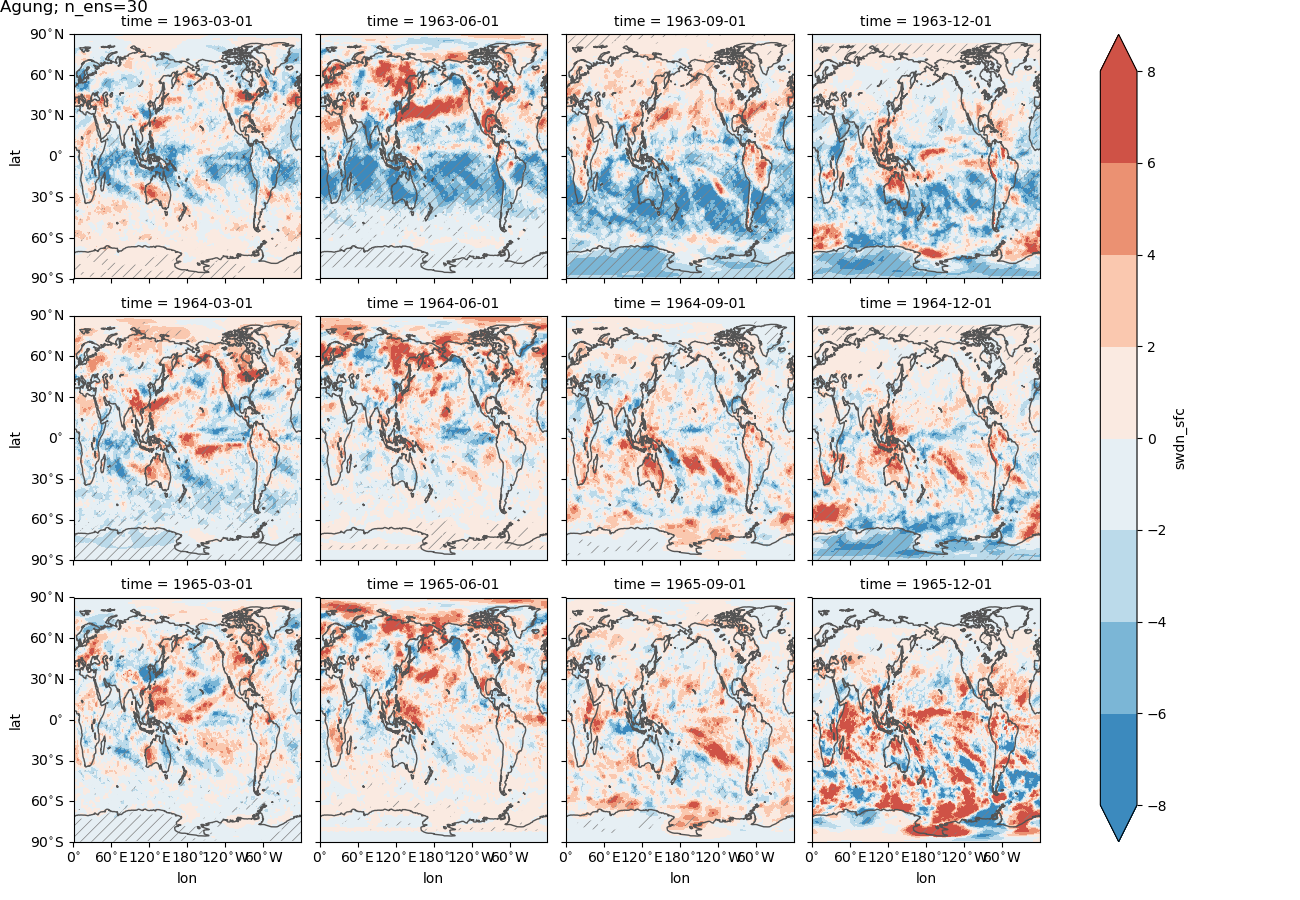

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Agung; n_ens=30')

In [8]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

In [9]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


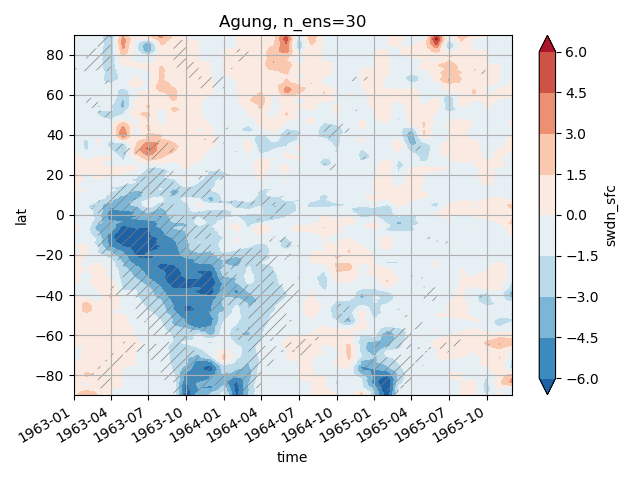

In [11]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

### Surface temperature ``t_surf``

In [57]:
%%time
data_name = 't_surf'

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_agung.ipynb.t_surf.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.t_surf.nc
CPU times: user 13 ms, sys: 8 ms, total: 21 ms
Wall time: 136 ms


In [59]:
%%time
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

CPU times: user 6.09 s, sys: 3.63 s, total: 9.73 s
Wall time: 9.7 s


<IPython.core.display.Javascript object>


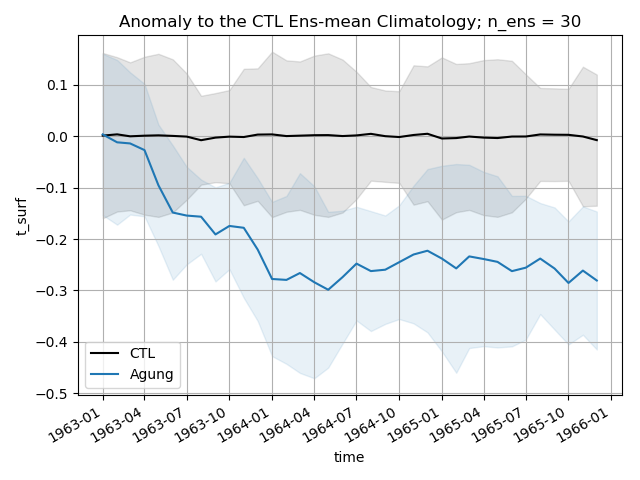

In [46]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

In [15]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


<IPython.core.display.Javascript object>


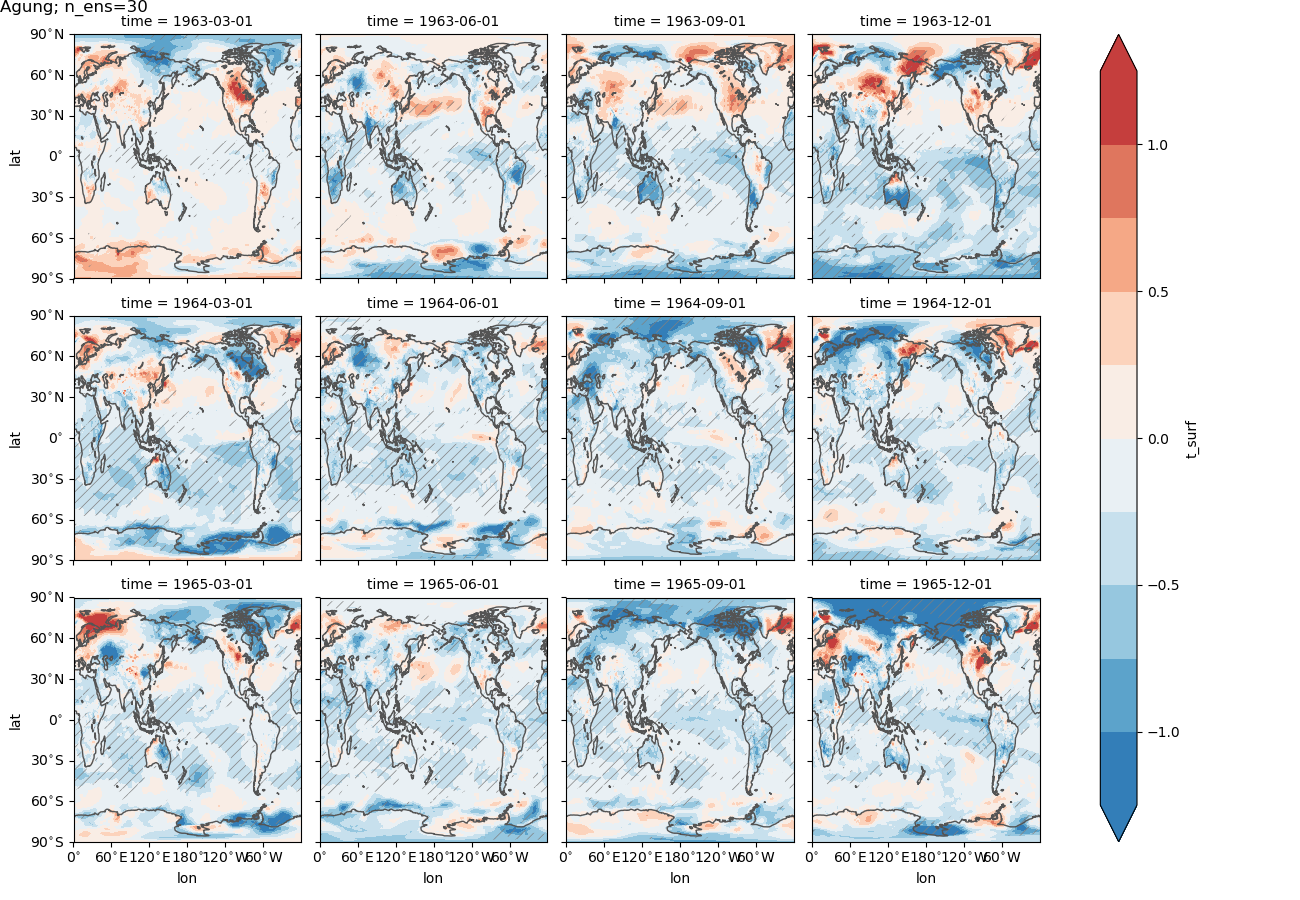

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Agung; n_ens=30')

In [16]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


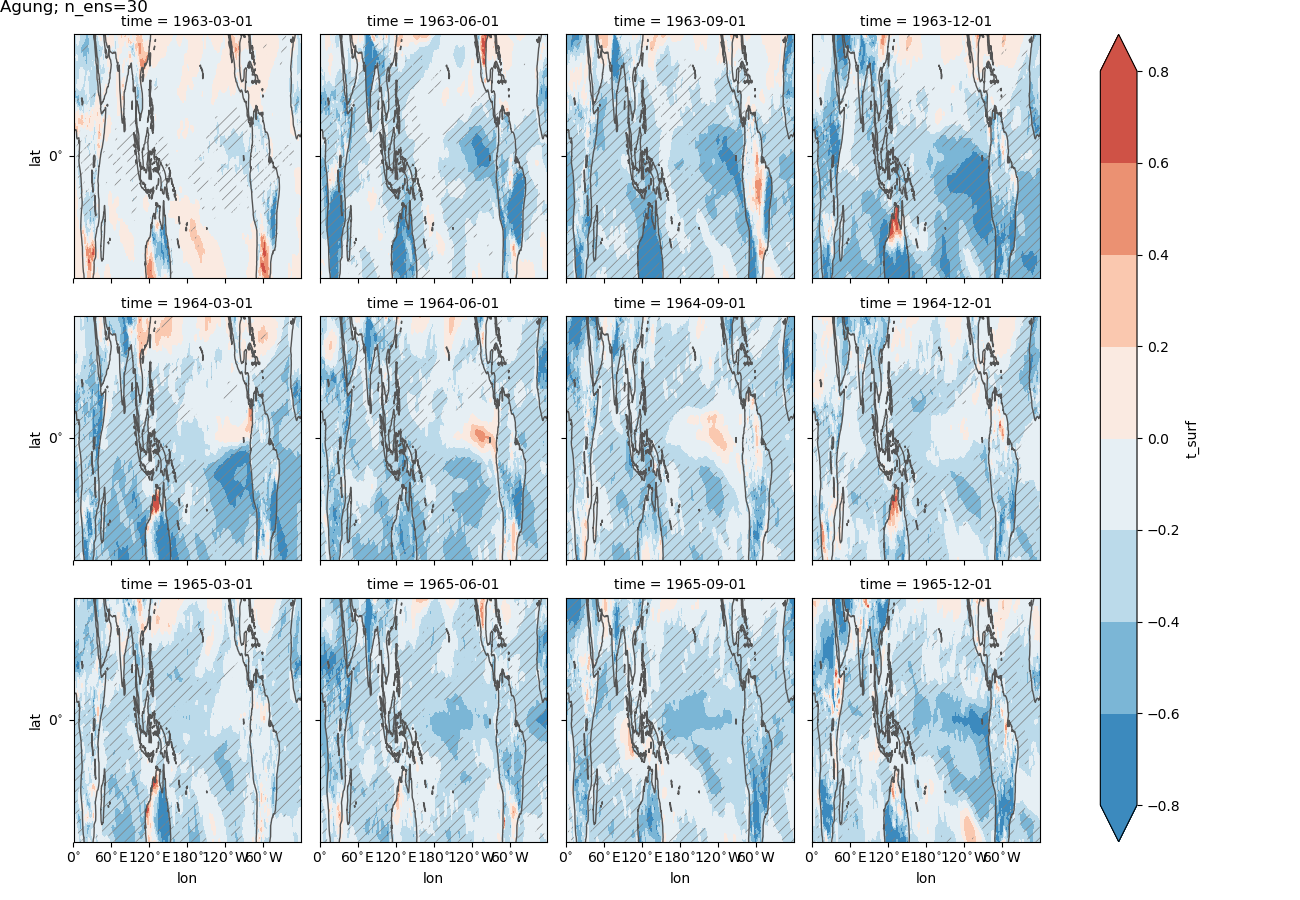

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Agung; n_ens=30')

In [17]:
# tropics only
latrange = slice(-30,30)
f = da.sel(lat=latrange).plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).sel(lat=latrange).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

In [18]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

<IPython.core.display.Javascript object>


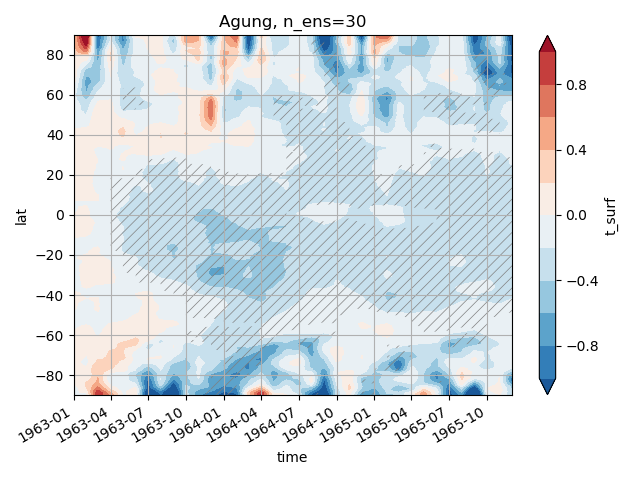

In [19]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

### Precipitation ``precip``

In [47]:
%%time
data_name = 'precip'
scale_factor = 3600*24

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

da_ctl = da_ctl * scale_factor
da_volcano = da_volcano * scale_factor

Data loaded from cache/volcano_impact_on_climate_agung.ipynb.precip.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.precip.nc
CPU times: user 488 ms, sys: 2.07 s, total: 2.56 s
Wall time: 2.57 s


In [48]:
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

<IPython.core.display.Javascript object>


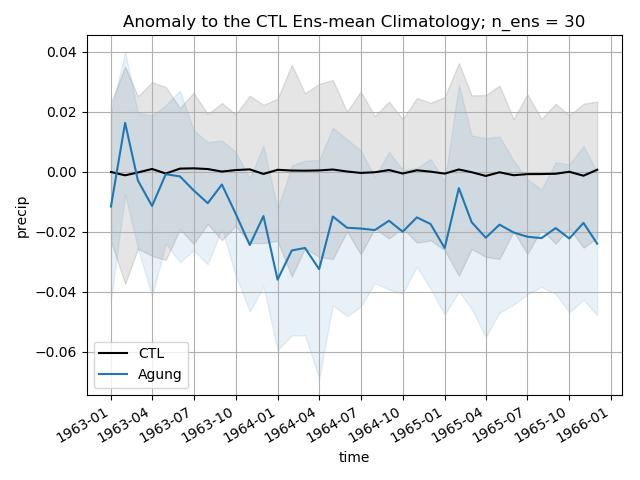

In [49]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

In [24]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


<IPython.core.display.Javascript object>


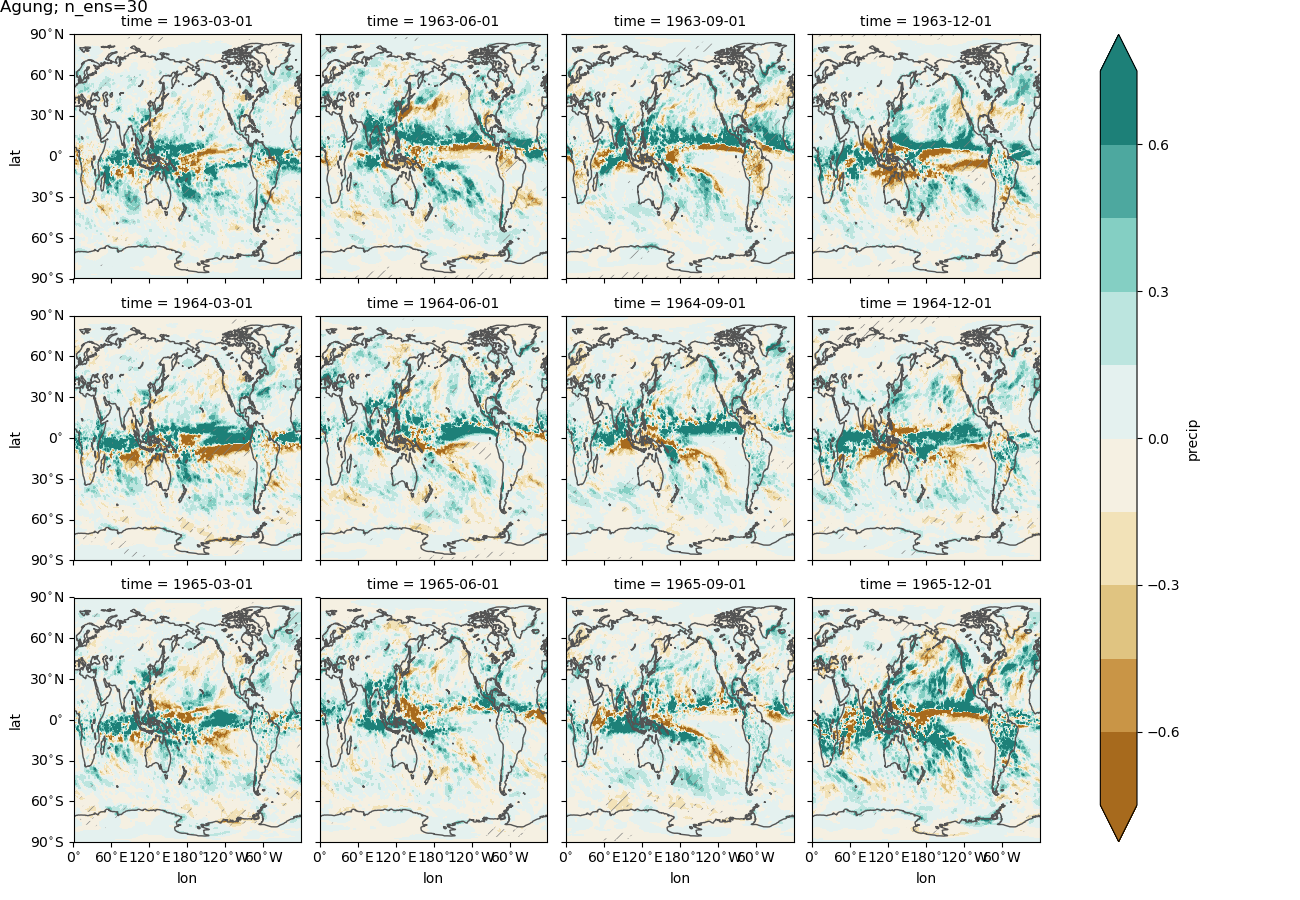

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Agung; n_ens=30')

In [25]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both', cmap='BrBG')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

In [26]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

<IPython.core.display.Javascript object>


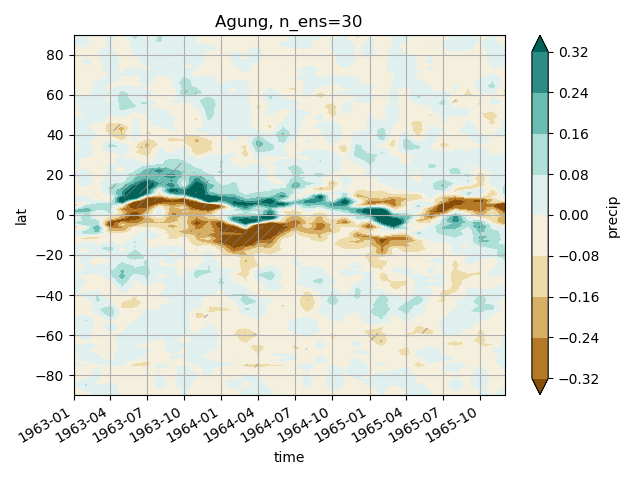

In [28]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0, cmap='BrBG')
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

### Sea level pressure ``slp``

In [37]:
%%time
data_name = 'slp'

ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_agung.ipynb.slp.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.slp.nc
CPU times: user 18 ms, sys: 15 ms, total: 33 ms
Wall time: 34.7 ms


In [38]:
# seasonal mean
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


<IPython.core.display.Javascript object>


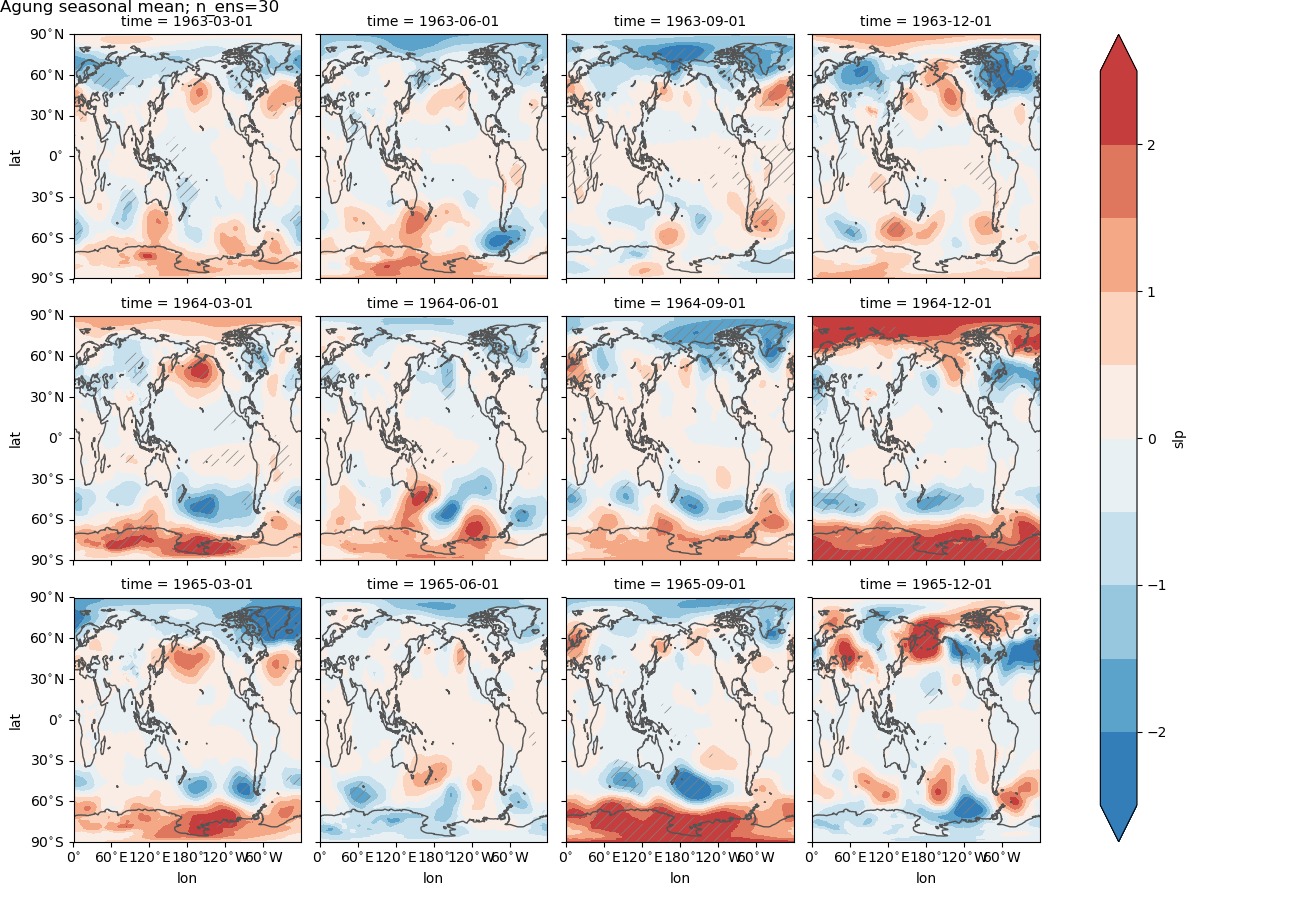

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Agung seasonal mean; n_ens=30')

In [39]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name} seasonal mean; n_ens={len(ens)}', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


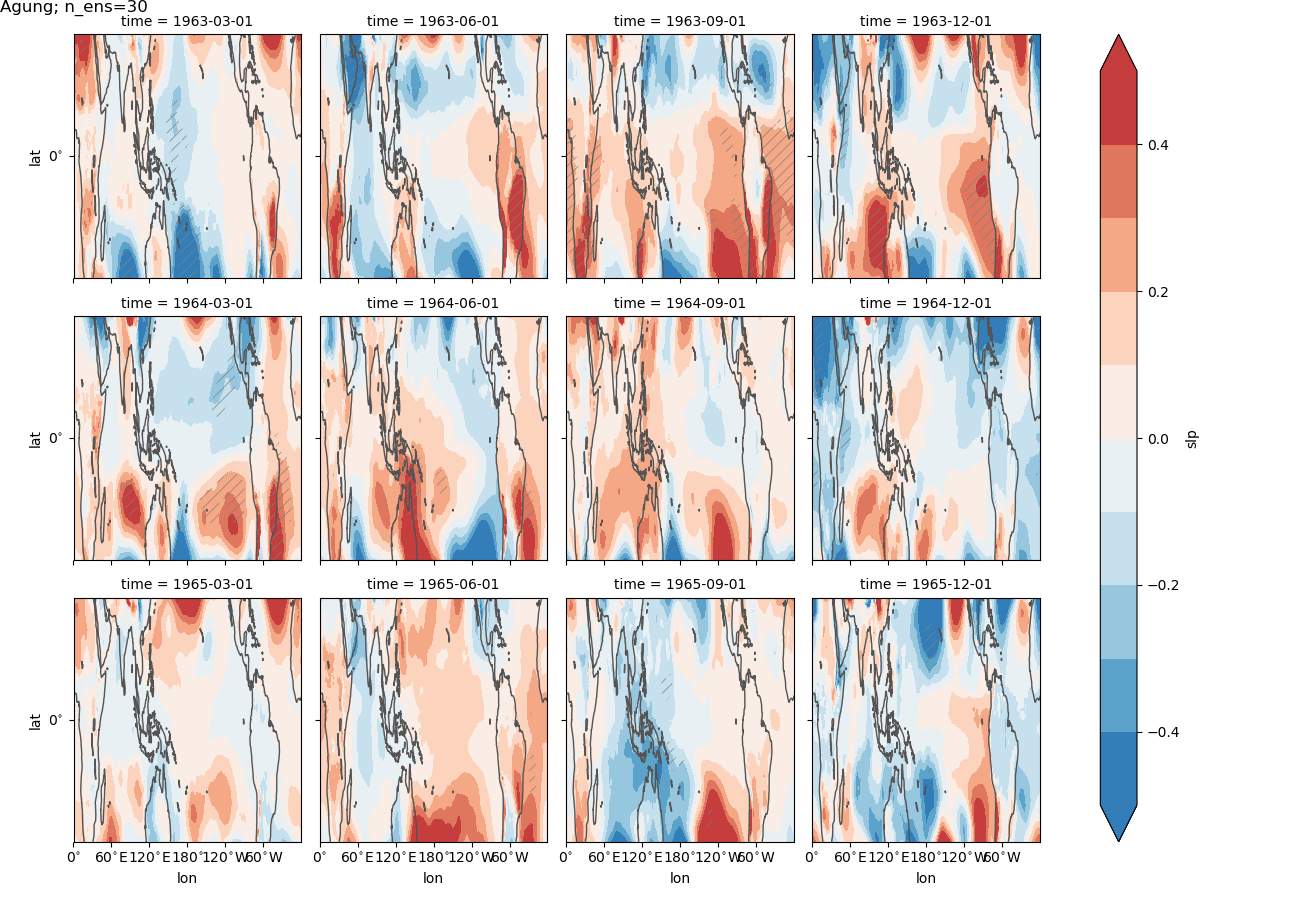

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Agung; n_ens=30')

In [40]:
# tropics only
latrange = slice(-30,30)
f = da.sel(lat=latrange).plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).sel(lat=latrange).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

### Zonal-mean temperature ``temp``

In [29]:
%%time
data_name = 'temp'

ncfile = f'cache/{nbname}.{data_name}.lonmean.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).mean('lon').load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.lonmean.nc'
try:
    da_volcano = xr.open_dataarray(ncfile)
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).mean('lon').load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_agung.ipynb.temp.lonmean.ctl.nc
Data loaded from cache/volcano_impact_on_climate_agung.ipynb.temp.lonmean.nc
CPU times: user 15 ms, sys: 4 ms, total: 19 ms
Wall time: 160 ms


In [30]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


<IPython.core.display.Javascript object>


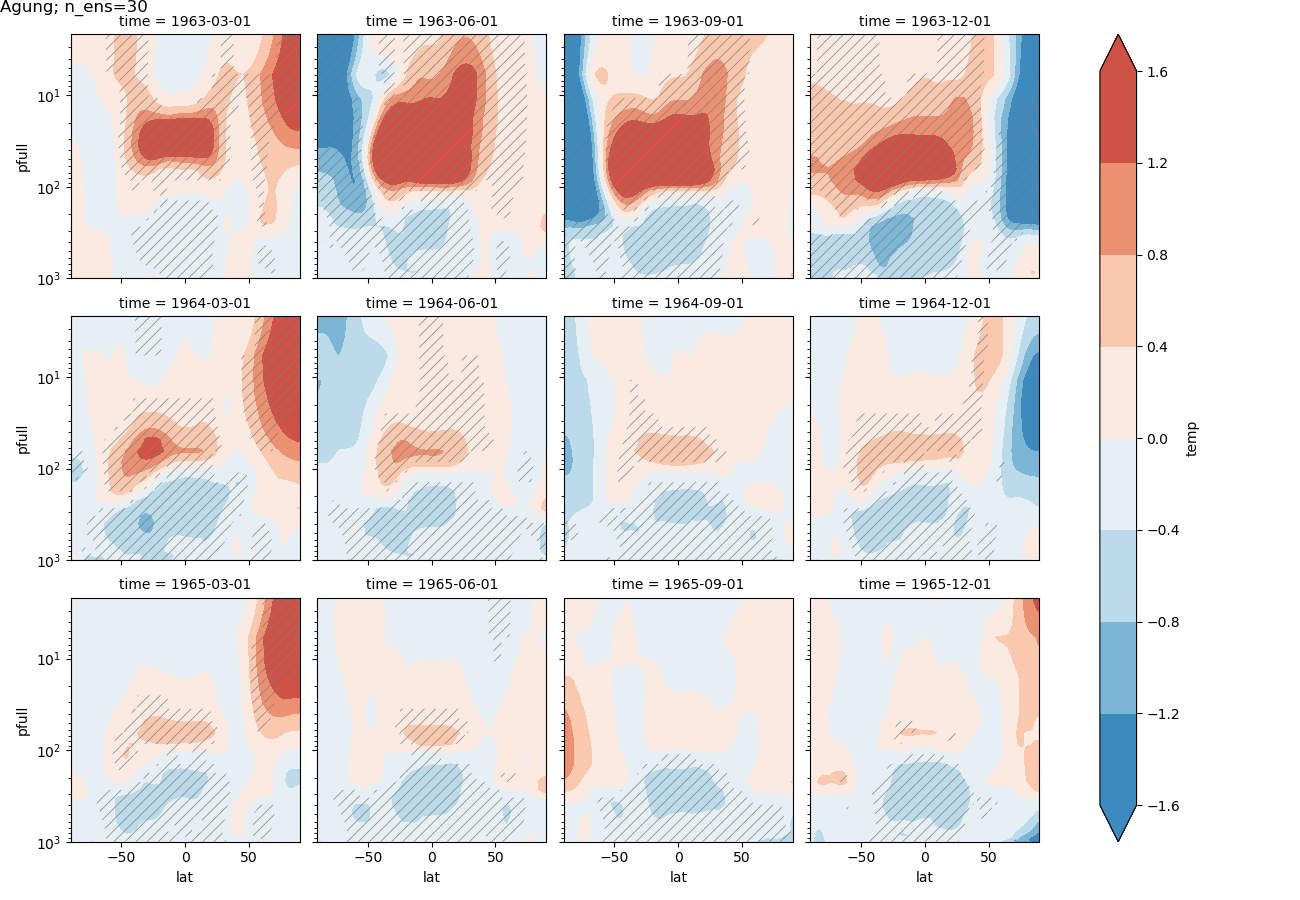

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'facecolor'
  s)


Text(0,1,'Agung; n_ens=30')

In [31]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both', yincrease=False)
for ii, ax in enumerate(f.axes.flat):
#     mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False, yincrease=False)
    ax.set_yscale('log')
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')